In [1]:
import warnings
warnings.filterwarnings(action='ignore')

# 핸즈온 머신러닝 2판 - Chapter 3 분류

## 3.1 MNIST

사이킷런에서 읽어 들인 데이터 셋 딕셔너리 구조

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


데이터셋에서 이미지 확인하기

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis("off")
plt.show()

print("실제 레이블 : ", print(y[0]))
print(type(y[0]))

KeyError: 0

In [ ]:
import numpy as np

print(y[0])
print(type(y[0]))
y = y.astype(np.uint8)
print(type(y[0]))

훈련 테스트 데이터 나누기

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:] 

## 3.2 이진 분류기 훈련

In [6]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [7]:
#사이컷런의 SGDClassifier를 사용한 확률적 경사 하강법 분류기(SGD)
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=22)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=22)

In [ ]:
#sgd 모델을 사용한 숫자 5 이미지 감지
print(sgd_clf.predict([some_digit]))
plt.imshow(some_digit_image, cmap='binary')
plt.show()

## 3.3 성능 측정

### 3.3.1 교차 검증을 사용한 정확도 측정

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=11)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred), end = ' ')

In [ ]:
# cross_val_score() 함수로 폴드가 3개인 k-겹 교차 검증
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy") 

모든 이미지를 5아님 클래스로 분류하는 더미 분류기 만들기

In [ ]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

### 3.3.2 오차 행렬

In [ ]:
# 실제 타깃과 비교할 수 있는 예측값 만들기
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3) 

In [ ]:
# 오차 행렬 만들기
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

### 3.3.3 정밀도와 재현율

In [ ]:
# 정밀도와 재현율
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

In [ ]:
# F1 score
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

### 3.3.4 정밀도/재현율 트레이드오프

In [ ]:
# decision_function() 메서드를 호출하면 각 샘플의 점수를 얻을 수 있다.
y_scores = sgd_clf.decision_function([some_digit])
y_scores

In [ ]:
# 임곗값이 0이므로, true를 반환한다.
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

In [ ]:
# 임곗값이 높이면 false를 반환한다.
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

In [ ]:
# cross_val_predict()로 훈련 세트에 있는 모든 샘플의 점수 구하기
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function" )

In [ ]:
# precision_recall_curve() 함수를 사용하여 모든 임곗값에 대한 정밀도와 재현율 계산
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fm.get_fontconfig_fonts()
font_location = "c:/Windows/Fonts/malgun.ttf"
font_name = fm.FontProperties(fname=font_location).get_name()
plt.rc('font', family=font_name)
%matplotlib inline


def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="정밀도")
    plt.plot(thresholds, recalls[:-1], "g--", label="재현율")
    plt.xlabel("임계값")
    plt.legend()


plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

정밀도 90% 달성하기

In [ ]:
# 최소한 90% 정밀도가 되는 가장 낮은 임곗값 찾기
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
# 예측 만들기
y_train_pred_90 = (y_scores >= threshold_90_precision) 

# 예측에 대한 정밀도와 재현율 확인
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

### 3.3.5 ROC 곡선

In [ ]:
# roc_curve()함수를 사용해 여러 임곗값에서 TPR과 FPR을 계산
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    #대각점선
    plt.plot([0.,1], [0, 1], 'k--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
plot_roc_curve(fpr, tpr)
plt.show()

In [ ]:
# AUC 계산하는 함수
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

In [ ]:
#RandomForestClassifier() : 랜덤분류기는 훈련 데이터의 클래스 비율을 따라 무작위로 예측
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method="predict_proba")

y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, "랜덤 포레스트")
plt.legend(loc='best')
plt.show()

In [ ]:
# RandomForestClassifier ROC AUC 점수
roc_auc_score(y_train_5, y_scores_forest)

## 3.4 다중 분류

In [ ]:
# 서포트 벡터 머신 분류기
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

In [ ]:
# 클래스별 결정 점수 확인
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

In [ ]:
print(np.argmax(some_digit_scores))
print(svm_clf.classes_)
print(svm_clf.classes_[5])

In [ ]:
# SVC 기반으로 OvR전략을 사용하는 다중 분류기
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=42))
ovo_clf.fit(X_train, y_train)
print(ovo_clf.predict([some_digit]))
print(len(ovo_clf.estimators_))

In [ ]:
# SGDClassifier 훈련시키기
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

In [ ]:
# SGD 분류기가 클래스마다 부여한 점수 확인
sgd_clf.decision_function([some_digit])

In [ ]:
# cross_val_score()함수를 사용해 SGDClassifier의 정확도 평가
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

In [ ]:
# 입력의 스케일을 조정해서 정확도 높이기
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

## 3.5 에러 분석

In [ ]:
#cross_val_predict() 함수를 사용해 예측을 만들고
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
#confusion_matrix(0 함수를 호출해 오차 행렬 살펴보기)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

In [ ]:
#matshow()을 통해 오차행렬을 이미지로 표현
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
#에러 비율
row_sums = conf_mx.sum(axis = 1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
#숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

In [ ]:
import matplotlib
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

## 3.6 다중 레이블 분류

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 ==1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

knn_clf.predict([some_digit])

In [ ]:
#다중 레이블 분류기를 평가하는 방법 : F1 점수의 평균을 계산
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

## 3.7 다중 출력 분류

In [ ]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [ ]:
# MNIST 이미지에 넘파이의 randint() 함수를 사용하여 픽셀 강도에 잡음 추가
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0,100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
some_index = 5501
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

In [ ]:
#잡음 제거
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

# 딥러닝 홀로서기 - #6.Lec ~ #7.Lec

## 1. Data Generation

Classification 실습에 사용할 데이터를 만들어봅시다. 이번에도 X가 2차원 Y가 1차원인 상황입니다. X는 모두 continuous space에 존재하고 Y는 class이기 때문에 discrete space에 분포합니다. 이번에는 방사형 데이터 분포를 가상으로 만든 후에 두 모델들이 비선형 decision-boundary를 형성할 수 있는지 테스트해보죠.

**Data Set**  
$$X_{train} \in \mathcal{R}^{8000 \times 2}, Y_{train} \in \mathcal{Z}^{8000}$$  
$$X_{val} \in \mathcal{R}^{1000 \times 2}, Y_{val} \in \mathcal{Z}^{1000}$$  
$$X_{test} \in \mathcal{R}^{1000 \times 2}, Y_{test} \in \mathcal{Z}^{1000}$$

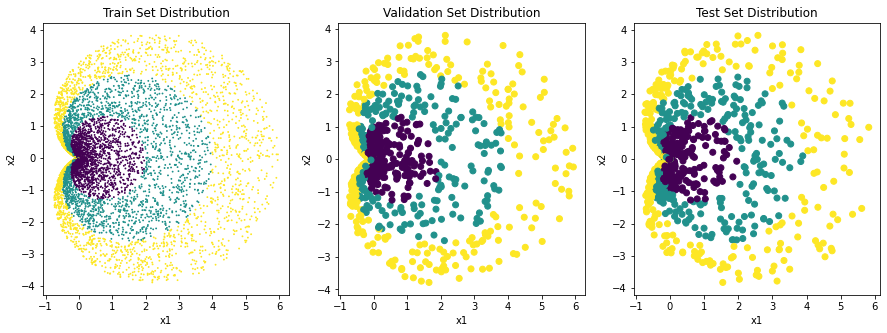

In [9]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt


# ====== Generating Dataset ====== #
r = np.random.rand(10000)*3
theta = np.random.rand(10000)*2*np.pi
y = r.astype(int)
r = r * (np.cos(theta) + 1)
x1 = r * np.cos(theta)
x2 = r * np.sin(theta)
X = np.array([x1, x2]).T

# ====== Split Dataset into Train, Validation, Test ======#
train_X, train_y = X[:8000, :], y[:8000]
val_X, val_y = X[8000:9000, :], y[8000:9000]
test_X, test_y = X[9000:, :], y[9000:]

# ====== Visualize Each Dataset ====== #
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1, 3, 1)
ax1.scatter(train_X[:, 0], train_X[:, 1], c=train_y, s=0.7)
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_title('Train Set Distribution')


ax2 = fig.add_subplot(1, 3, 2)
ax2.scatter(val_X[:, 0], val_X[:, 1], c=val_y)
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_title('Validation Set Distribution')

ax3 = fig.add_subplot(1, 3, 3)
ax3.scatter(test_X[:, 0], test_X[:, 1], c=test_y)
ax3.set_xlabel('x1')
ax3.set_ylabel('x2')
ax3.set_title('Test Set Distribution')

plt.show()

## 2. Hypothesis Define (Model Define)

Logistic Regression Model을 파이토치로 구현할 때는 Regression 문제를 풀 때와 똑같이 `nn.Linear` 모듈과 non-linear activation fuction만 달아주면 됩니다. **Model 내에서 Softmax를 사용할 필요가 없습니다..!** 그 이유는 softmax 함수가 뒤에 나오는 파이썬 내장 **CrossEntropyLoss 함수에 들어가** 있기 때문이죠.


**Multi-Label Logistic Model**   
$$z = \ XW + b \ \ ( W \in \mathcal{R}^{2 \times 3}, b \in \mathcal{R}^{3}, z \in \mathcal{R}^{N \times 3}$$  
$$H = \ softmax(z) \ \ (  H \in \mathcal{R}^{N \times 3})$$  


**MLP Model**
$$Let \ relu(X) = \ max(X, 0)$$  

$$h = \ relu(X W_1 + b_1) \ \  ( W_1 \in \mathcal{R}^{2 \times 200}, b_1 \in \mathcal{R}^{200}, h \in \mathcal{R}^{N \times 200}$$  

$$z = \ h W_2 + b_2  \ \  ( W_2 \in \mathcal{R}^{200 \times 3}, b_2 \in \mathcal{R}^{3}, z \in \mathcal{R}^{N  \times 3})$$  

$$H = \ softmax(z) \ \ ( H \in \mathcal{R}^{N \times 3})$$  

In [10]:
import torch
import torch.nn as nn


class LinearModel(nn.Module):
    def __init__(self): 
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features=2, out_features=3, bias=True)
    
    def forward(self, x):
        x = self.linear(x)
        return x

    
class MLPModel(nn.Module):
    def __init__(self): 
        super(MLPModel, self).__init__()
        self.linear1 = nn.Linear(in_features=2, out_features=200)
        self.linear2 = nn.Linear(in_features=200, out_features=3)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

## 3. Cost Function Define (Loss Function Define)

Multi-Label Problem 에서의 Loss Function을 작성해봅시다.  
파이토치의 `nn` 아래에는 다양한 Loss Function이 이미 구현되어 있습니다.  
[여기](https://pytorch.org/docs/stable/_modules/torch/nn/modules/loss.html)에서 파이토치 내부에 구현되어 있는 MSE, Cross-Entropy, KL-Divergence 등을 확인할 수 있습니다.  
이 실습에서는 Classification Problem 이므로 `CrossEntropyLoss()`를 사용해봅시다.  

`input`은 $ N \times Num Class $ 차원을 가지면 되며 float 형태여야 하고,  
`target`은 $ N $ 차원을 가지고 각 엘리먼트는 $ i $ 번째 클래스를 나타내는 int형이면 되는군요.

CrossEntropy Documentation : https://pytorch.org/docs/stable/nn.html#crossentropyloss

In [11]:
cls_loss = nn.CrossEntropyLoss()

test_pred_y = torch.Tensor([[2,0.1],[0,1]])
test_true_y1 = torch.Tensor([1,0]).long()
test_true_y2 = torch.Tensor([0,1]).long()

print(cls_loss(test_pred_y, test_true_y1))
print(cls_loss(test_pred_y, test_true_y2))

tensor(1.6763)
tensor(0.2263)


## 4. Train & Evaluation

이제 모델도 정의했고 Loss Function도 정의했으니 한번 학습시켜볼까요?  
저번에는 저희가 직접 파라미터(w 하나)에 따른 loss의 편미분을 유도하고 거기서 나온 그라디언트로 w를 업데이트했는데요.  
`pytorch`에서는 loss.backward() 라는 기능을 쓰면 알아서 loss를 계산되는데 사용한 각 파라미터에 대한 loss의 편미분을 계산해줍니다.  
이후 `optimizer.step()` 함수를 사용하면 각 파라미터의 그라디언트를 바탕으로 파라미터의 값을 조금씩 업데이트 해줍니다. 

이 때 모델은 매 Iteration 때마다 Train Set에 의해 학습되면서 동시에 Validation Set을 넣고 Loss를 비교하게 됩니다. 
그리고 저희가 평가하고 싶은 때마다 (지금은 200번) Test Set을 넣고 Visualize 하는데 필요한 Predicted y값과 Metric 값을 계산합니다.  
이번에는 Classification Task에서 기본적으로 사용하는 **Accuracy**를 **Metric**으로 활용해보겠습니다.  
accuracy를 계산하는 함수가 이미 `sklearn.metrics`에 구현되어 있으니 불러와 사용하도록 합시다.  

accuracy_score Documentation : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
  
  
$$ Accuracy = \frac{Number \ of \ correct \ prediction}{Total \ number \ of \ predictions \ made} $$

Parameter containing:
tensor([[ 0.6886,  0.2576],
        [ 0.1616, -0.5507],
        [ 0.5363,  0.0780]], requires_grad=True)
Parameter containing:
tensor([-0.1426, -0.6489,  0.0429], requires_grad=True)
1203 parameters


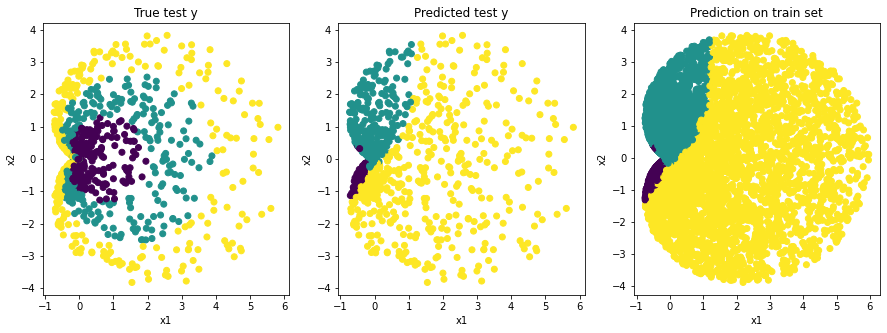

Epoch:  0 Accuracy:  29.299999999999997 %


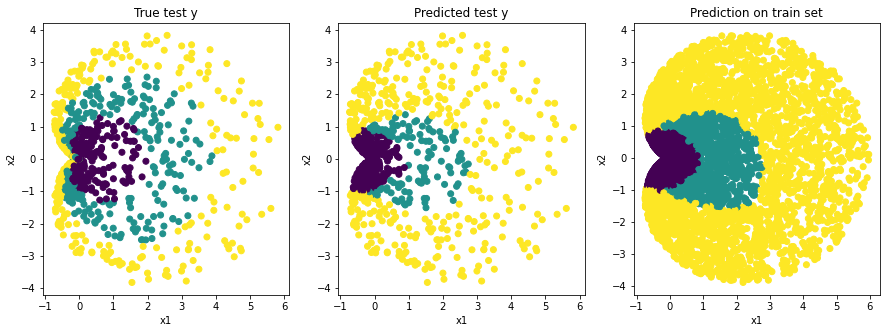

Epoch:  200 Accuracy:  53.0 %


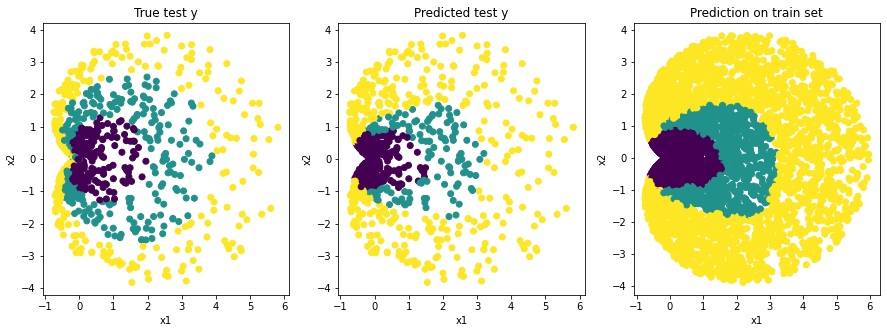

Epoch:  400 Accuracy:  61.0 %


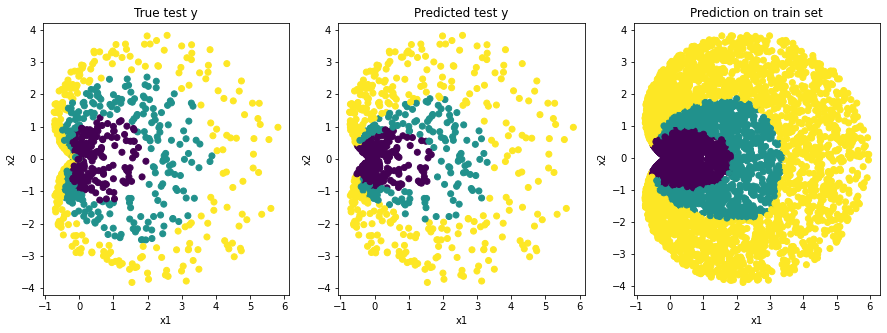

Epoch:  600 Accuracy:  66.9 %


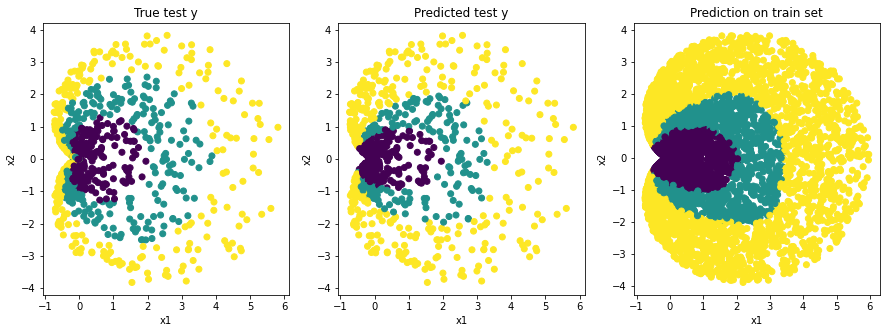

Epoch:  800 Accuracy:  69.89999999999999 %


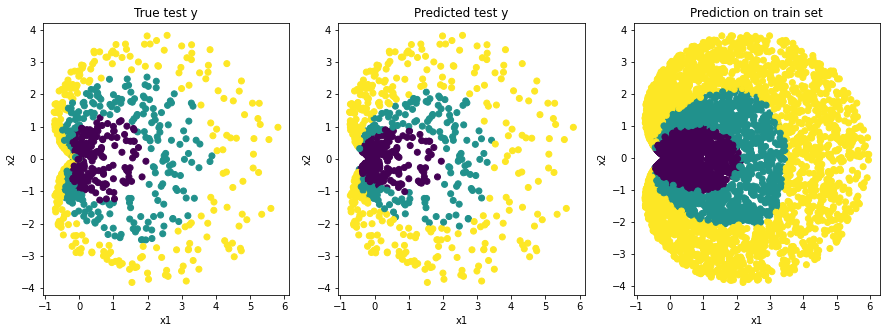

Epoch:  1000 Accuracy:  71.5 %


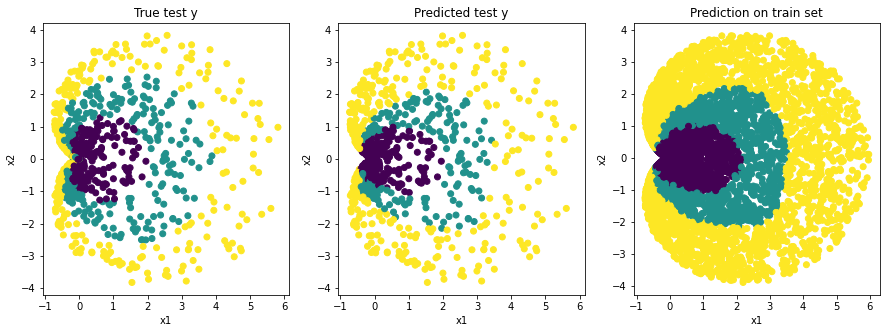

Epoch:  1200 Accuracy:  72.8 %


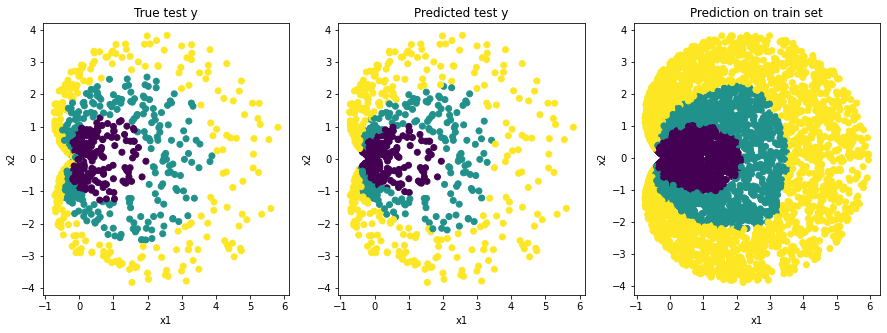

Epoch:  1400 Accuracy:  73.9 %


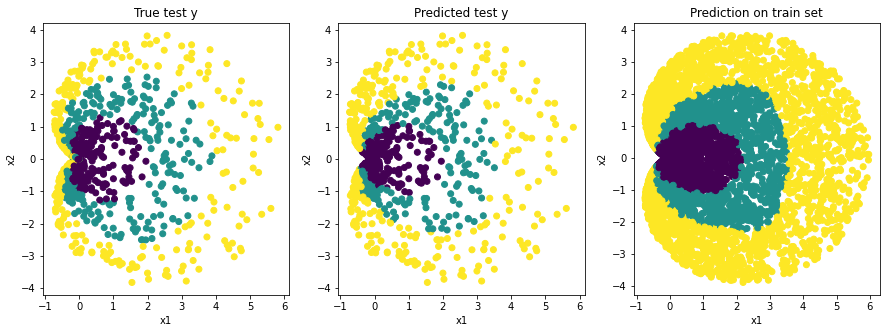

Epoch:  1600 Accuracy:  74.9 %


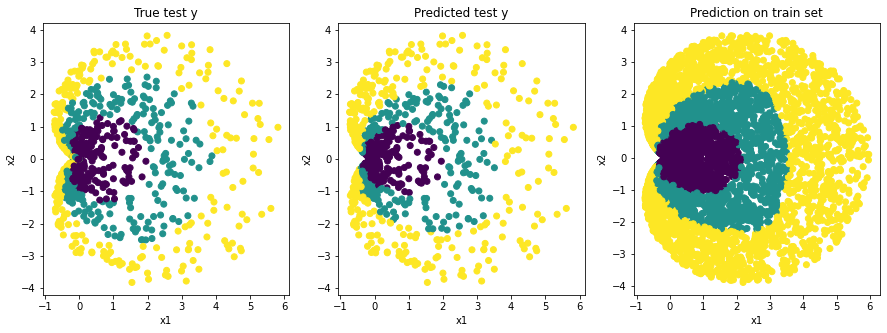

Epoch:  1800 Accuracy:  75.3 %


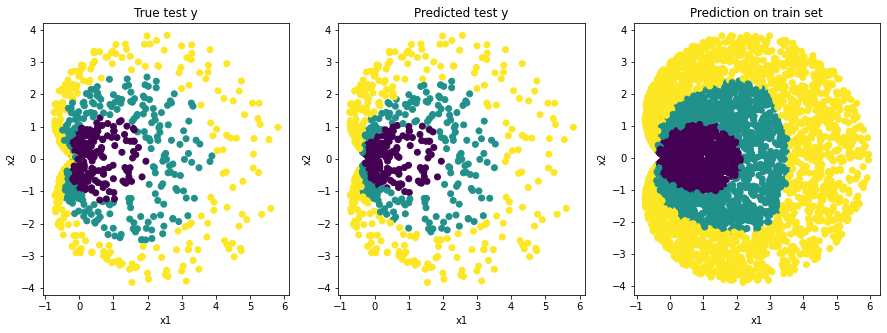

Epoch:  2000 Accuracy:  76.3 %


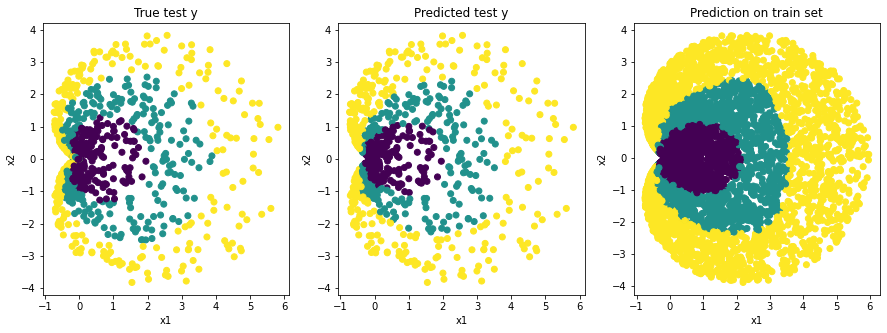

Epoch:  2200 Accuracy:  76.4 %


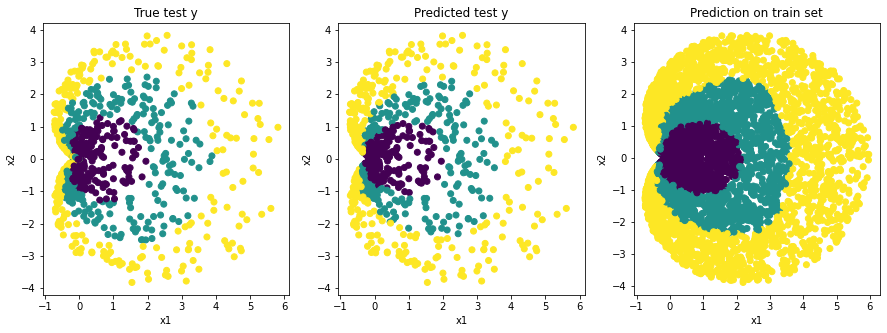

Epoch:  2400 Accuracy:  77.2 %


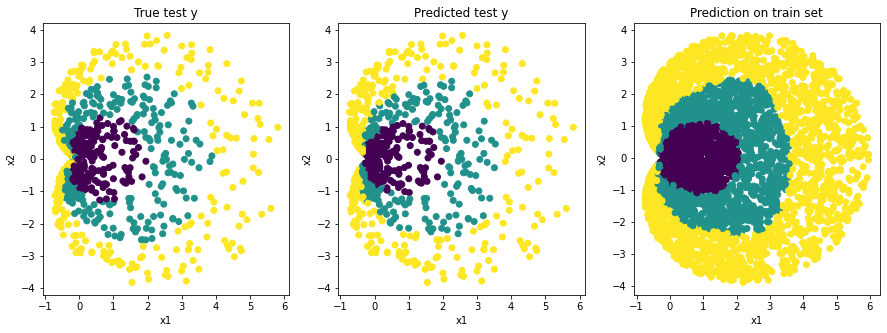

Epoch:  2600 Accuracy:  78.10000000000001 %


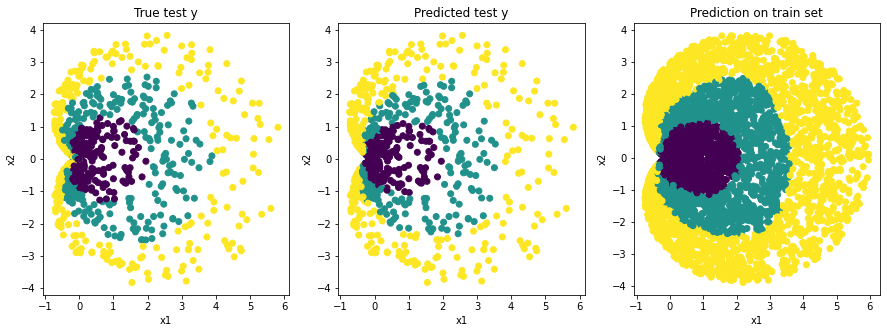

Epoch:  2800 Accuracy:  78.5 %


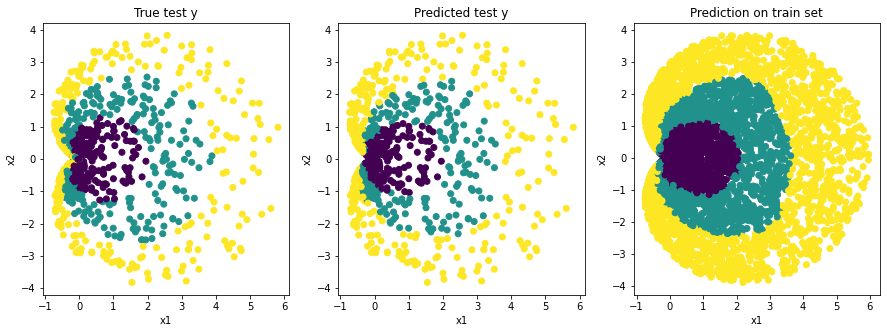

Epoch:  3000 Accuracy:  78.60000000000001 %


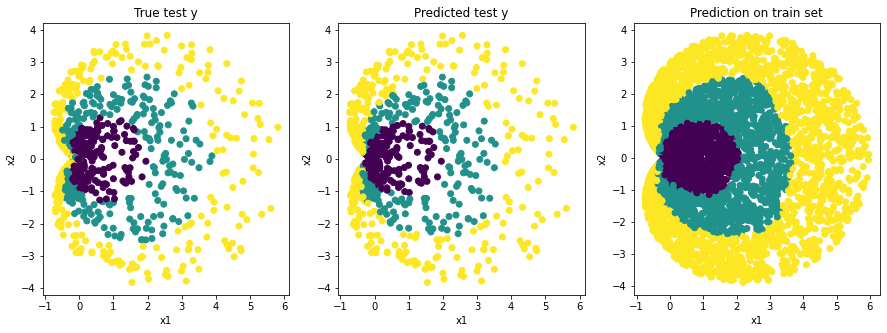

Epoch:  3200 Accuracy:  78.4 %


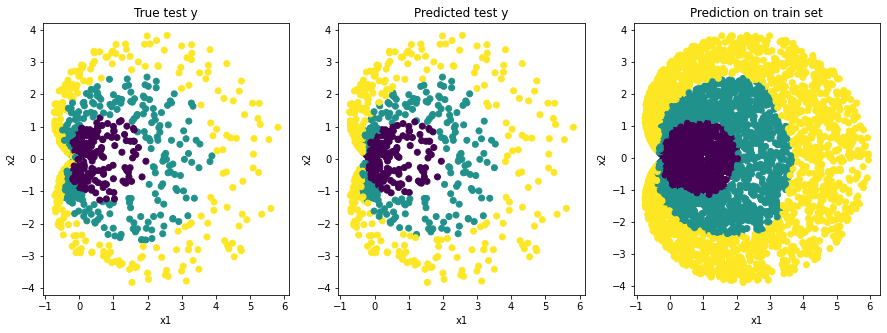

Epoch:  3400 Accuracy:  78.9 %


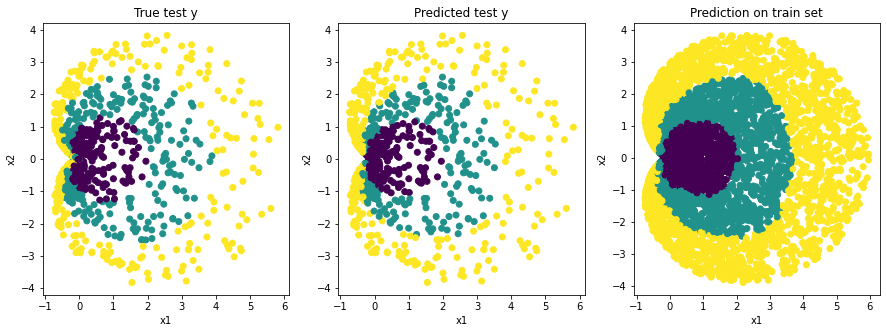

Epoch:  3600 Accuracy:  79.0 %


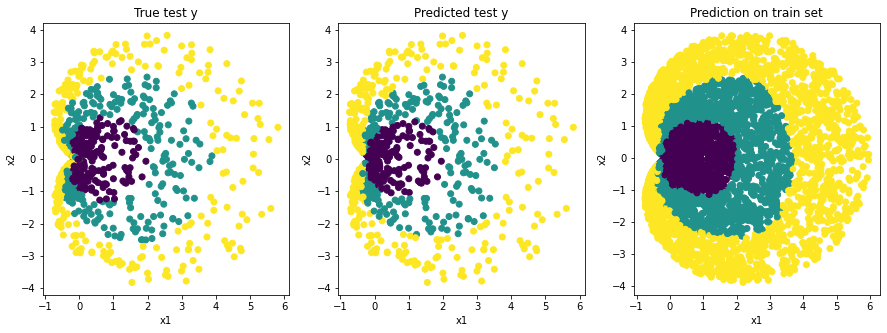

Epoch:  3800 Accuracy:  79.2 %


In [12]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

# ====== Construct Model ====== #
model = LinearModel()
print(model.linear.weight)
print(model.linear.bias)

model = MLPModel() # Model을 생성해줍니다.
print('{} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad))) # 복잡해보이지만 간단히 모델 내에 학습을 당할 파라미터 수를 카운팅하는 코드입니다.

# ===== Construct Optimizer ====== #
lr = 0.005 # Learning Rate를 하나 정해줍니다. (원할한 학습을 위해 손을 많이 탑니다)
optimizer = optim.SGD(model.parameters(), lr=lr) # Optimizer를 생성해줍니다.

# 매 학습 단계에서의 epoch값과 그 때의 loss 값을 저장할 리스트를 만들어줍시다.
list_epoch = [] 
list_train_loss = []
list_val_loss = []
list_acc = []
list_acc_epoch = []


epoch = 4000 # 학습 횟수(epoch)을 지정해줍시다.
for i in range(epoch):
    
    # ====== Train ====== #
    model.train() # model을 train 모드로 세팅합니다. 반대로 향후 모델을 평가할 때는 eval() 모드로 변경할 겁니다 (나중 실습에서 쓸 겁니다)
    optimizer.zero_grad() # optimizer에 남아있을 수도 있는 잔여 그라디언트를 0으로 다 초기화해줍니다.
    
    input_x = torch.Tensor(train_X)
    true_y = torch.Tensor(train_y).long()
    pred_y = model(input_x)
    #print(input_x.shape, true_y.shape, pred_y.shape) # 각 인풋과 아웃풋의 차원을 체크해봅니다.
    
    loss = cls_loss(pred_y.squeeze(), true_y)
    loss.backward() # backward()를 통해서 그라디언트를 구해줍니다.
    optimizer.step() # step()을 통해서 그라디언틀르 바탕으로 파라미터를 업데이트 해줍니다. 
    list_epoch.append(i)
    list_train_loss.append(loss.detach().numpy())
    
    
    # ====== Validation ====== #
    model.eval()
    optimizer.zero_grad()
    input_x = torch.Tensor(val_X)
    true_y = torch.Tensor(val_y).long()
    pred_y = model(input_x)   
    loss = cls_loss(pred_y.squeeze(), true_y)
    list_val_loss.append(loss.detach().numpy())
    

    # ====== Evaluation ======= #
    if i % 200 == 0: # 200회의 학습마다 실제 데이터 분포와 모델이 예측한 분포를 그려봅니다.
        
        # ====== Calculate Accuracy ====== #
        model.eval()
        optimizer.zero_grad()
        input_x = torch.Tensor(test_X)
        true_y = torch.Tensor(test_y)
        pred_y = model(input_x).detach().max(dim=1)[1].numpy() 
        acc = accuracy_score(true_y, pred_y) # sklearn 쪽 함수들은 true_y 가 먼저, pred_y가 나중에 인자로 들어가는 것에 주의합시다
        list_acc.append(acc)
        list_acc_epoch.append(i)

        fig = plt.figure(figsize=(15,5))
        
        # ====== True Y Scattering ====== #
        ax1 = fig.add_subplot(1, 3, 1)
        ax1.scatter(test_X[:, 0], test_X[:, 1], c=test_y)
        ax1.set_xlabel('x1')
        ax1.set_ylabel('x2')
        ax1.set_title('True test y')
        
        # ====== Predicted Y Scattering ====== #
        ax2 = fig.add_subplot(1, 3, 2)
        ax2.scatter(test_X[:, 0], test_X[:, 1], c=pred_y)
        ax2.set_xlabel('x1')
        ax2.set_ylabel('x2')
        ax2.set_title('Predicted test y')
        
        # ====== Just for Visualizaing with High Resolution ====== #
        input_x = torch.Tensor(train_X)
        pred_y = model(input_x).detach().max(dim=1)[1].numpy() 
        
        ax3 = fig.add_subplot(1, 3, 3)
        ax3.scatter(train_X[:, 0], train_X[:, 1], c=pred_y)
        ax3.set_xlabel('x1')
        ax3.set_ylabel('x2')
        ax3.set_title('Prediction on train set')

        plt.show()
        print('Epoch: ', i,  'Accuracy: ', acc*100, '%')

## 5. Report Experiment

학습 과정에서 기록했던 train_loss와 val_loss를 그려봅시다.   
Loss가 꾸준히 줄어드는지 확인하고 val_loss가 증가하기 시킨다면 그 이상의 학습은 점점 모델의 성능을 망침을 뜻합니다. 
그 옆에는 Epoch에 따라서 MAE metric이 얼마나 감소하는지 확인해봅시다.

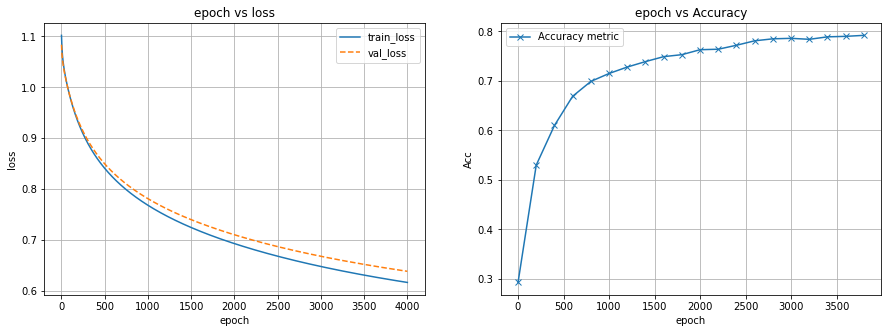

In [13]:
fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== Metric Fluctuation ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_acc_epoch, list_acc, marker='x', label='Accuracy metric')
ax2.set_xlabel('epoch')
ax2.set_ylabel('Acc')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs Accuracy')

plt.show()